# AP2 - Pré-traitement (nettoyage) des données MEG et EEG
Ce tutoriel est inspiré de [ceux de Dr. Jas](https://jasmainak.github.io/mne-workshop-brown/readme.html). N'hésitez pas à les consulter pour aller plus loin. Les tutoriels disponibles dans la [documentation de MNE-Python](https://mne.tools/stable/auto_tutorials/index.html) sont également une excellente ressource.

## Introduction de l'activité
Lors de l'acquisition de données électrophysiologiques, le signal provenant de l'activité cérébrale est souvent entaché de divers signaux parasites provenant de sources non cérébrales (par exemple, activité cardiaque, musculaire) ou même de sources non physiologiques (par exemple, bruit de la ligne électrique). La première étape avant d'analyser le signal pour en tirer des interprétations est donc de le nettoyer de tous ces *artefacts*.

Voici les sources d'artefacts les plus courantes dans le signal MEG/EEG :
- Clignements des yeux
- Mouvements oculaires (saccades, poursuite oculaire, etc.)
- Activité cardiaque
- Capteurs défectueux
- Bruit de la ligne électrique
- Mouvements de tête du sujet

Il existe plusieurs façons de traiter ces artefacts. On peut :
- Corriger les données (par exemple, à l'aide de l'ICA)
- Ignorer les données contaminées
- Combiner les deux approches ci-dessus (par exemple, avec AutoReject)

L'approche choisie dépendra du type d'artefacts que l'on cherche à éliminer du signal.

## Notre *pipeline* de nettoyage :

- Filtrage
    - Suppression des *drifts* (changements d'impédance ou mouvements des capteurs/du sujet)
    - Suppression du bruit haute fréquence
    - Suppression du bruit créé par la ligne de courant électrique
- ICA 
    - Suppression des mouvements et clignements des yeux (à l'aide de l'EOG)
    - Suppression de l'activité cardiaque (à l'aide de l'ECG)
- AutoReject
    - Correction ou rejet des capteurs et des segments/*epochs* bruités

## Charger les données
*Vous connaissez le principe.* Rien de nouveau ici.

In [2]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = op.join(mne.datasets.sample.data_path(), 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(data_path, preload=True)

Opening raw data file /Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


## Filtrage (temporel)
Pour commencer, observons le spectre des données brutes (non nettoyées, non transformées).

Effective window size : 3.410 (s)
Aggregating Welch estimates (median) before plotting...


/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


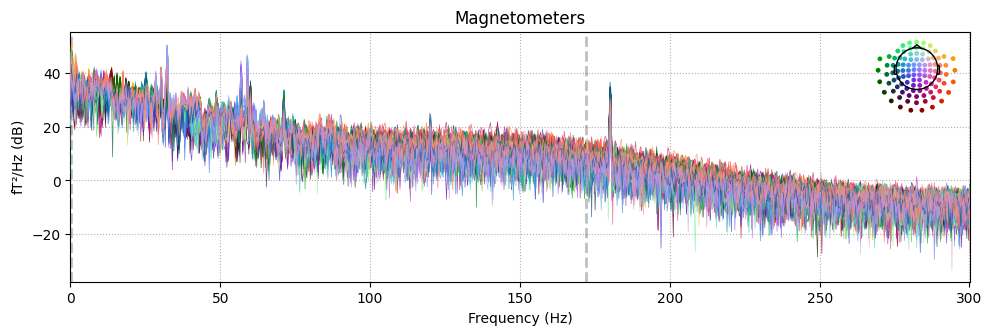

In [4]:
raw.compute_psd(tmax=10.0, picks='mag', average=False).plot();

On peut observer des pics de puissance à des fréquences régulièrement espacées.  
Ces pics sont causés par l'alternance du courant dans la ligne électrique qui alimente tous les appareils environnants. Au Québec, les lignes Hydro-Québec produisent un courant alternatif à 60 Hz, on peut donc observer un pic à 60, 120, 180 Hz (les multiples entiers de 60 Hz) et parfois même au-dessus lorsque la fréquence d'échantillonnage de notre signal permet d'encoder de telles fréquences.

Pour supprimer cet artefact, il est approprié d'utiliser un filtre *notch*. Il s'agit en réalité d'un filtre "coupe-bande" (l'inverse d'un "passe-bande"), dont la bande de coupure est extrêmement fine. Ces filtres permettent d'atténuer une fréquence sans toucher aux fréquences plus basses ou plus élevées.

La fréquence à laquelle cet artefact est visible varie donc en fonction de l'endroit où les données auront été collectées. Généralement : 
- 60 Hz en Amérique du Nord
- 50 Hz en Europe
- Si vous ne savez pas quelle fréquence retirer, identifiez les pics régulièrement espacés sur le spectre, et déduisez-en la fréquence fondamentale (= l'espace entre les pics)

Pour cela, on peut utiliser la méthode [Raw.notch_filter()](https://predictablynoisy.com/mne-python/generated/mne.io.Raw.html#mne.io.Raw.notch_filter), à laquelle nous passerons toutes les fréquences entre 60 et 180 Hz qui sont un multiple entier de 60.

Effective window size : 3.410 (s)
Aggregating Welch estimates (median) before plotting...


/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


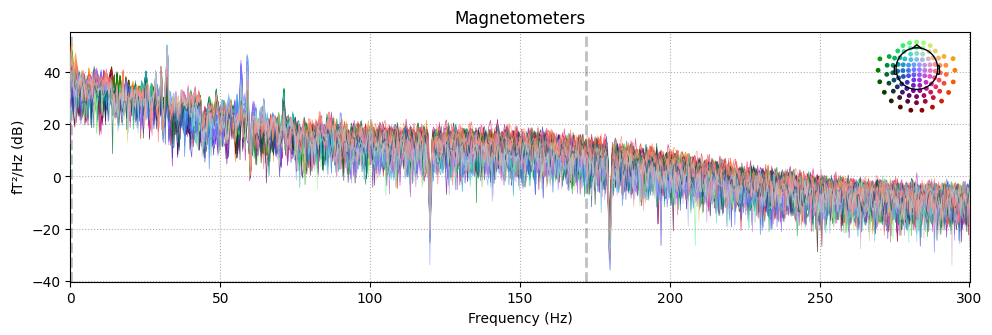

In [5]:
# Filtre *notch* pour supprimer les artefacts de fréquence électrique (60 Hz et ses harmoniques)
raw.notch_filter(np.arange(60, 181, 60), picks='mag', filter_length='auto',
                 phase='zero', verbose=False)

# Affichage du spectre de puissance pour les capteurs MEG (magnétomètre) après application du filtre *notch*
raw.compute_psd(tmax=10.0, picks='mag', average=False).plot();

In [12]:
# Question 1: En regardant les deux grapheique, quel est l'effet du filtre *notch* sur le spectre de puissance des capteurs MEG (magnétomètre) ?
# ADD DESCRIPTION HERE

In [ ]:
# Question 2: Refaire la procédure pour les capteurs MEG (GRADIOMÈTRE):
ADD CODE HERE
ADD CODE HERE

En MEG et en EEG, les fréquences supérieures à bande gamma (60-200 Hz) sont rarement étudiées, car elles contiennent très peu d'activité physiologique. Nous pouvons les éliminer de notre signal en utilisant un filtre passe-bas (*low-pass*). Dans cet exemple, nous appliquons un filtre passe-bas avec une fréquence de coupure (*cutoff*) de 150 Hz.

Pour ce faire, nous utilisons la méthode [Raw.filter()](https://predictablynoisy.com/mne-python/generated/mne.io.Raw.html#mne.io.Raw.filter).

Même chose pour les fréquences inférieures à 0.1 voir même 1Hz : il s'agit généralement de lentes variations de potentiel (ou de champ magnétique) causées par les mouvements du sujets, des changements d'impédance ou de la connectivité de la peau. Nous utiliserons dans ce cas un filtre passe-haut.

Remarquez les arguments de la fonction filter : le premier argument donne le "*low cutoff*", tandis que le second donne le "*high cutoff*". Pour faire un filtrage passe-haut, il faut donc spécifier un *low cutoff*. Si on spécifiait les deux cutoffs simultanément on ferait donc un filtrage passe-bande. Puisque nous avons déjà filtré les hautes fréquences, laissons le *high cutoff* à None.

Effective window size : 3.410 (s)
Aggregating Welch estimates (median) before plotting...


/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


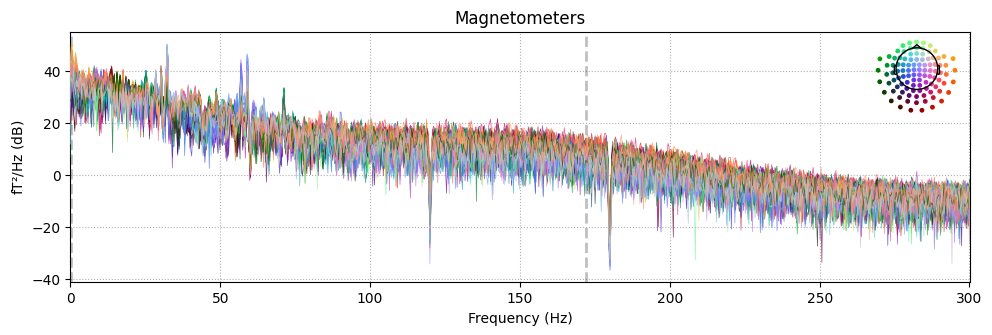

In [6]:
# Filtre passe-haut pour supprimer les basses fréquences du signal (fréquence de coupure : 0.1 Hz)
raw.filter(l_freq = 0.1, h_freq=None, fir_window='hamming', fir_design='firwin', verbose=False)

# Affichage du spectre de puissance pour les capteurs MEG (magnétomètre) après application du filtre passe-haut
raw.compute_psd(tmax=10.0, picks='mag', average=False).plot();

In [15]:
# Question 3: En regardant les deux grapheique, quel est l'effet du filtre passe-haut sur le spectre de puissance des capteurs MEG (magnétomètre) ?
# ADD DESCRIPTION HERE

In [ ]:
# Question 4: Trouver les paramètres pour appliquer un filtre passe-bande entre 1 et 60 Hz pour les capteurs MEG:
raw.filter(l_freq = ADD CODE HERE, h_freq=ADD CODE HERE, fir_window='hamming', fir_design='firwin', verbose=False)
# Il est possible de tester plusieurs combinaisons de paramètres pour trouver la meilleure solution, 
# Il y a plusieurs paramètres à tester: l_freq, h_freq, fir_window, fir_design ...

## Correction d'artefacts à l'aide de l'ICA (Analyse de Composantes Indépendantes)
Notre signal a maintenant été nettoyé de toutes les fréquences superflues. Cependant, les clignements des yeux et les battements cardiaques génèrent une activité dont le spectre se situe généralement entre 1 et 60 Hz, exactement dans la bande de fréquences qui nous intéresse. Par conséquent, nous ne pouvons pas filtrer ces artefacts. Nous devons utiliser l'ICA, une méthode qui nous permet de décomposer notre signal en différentes *composantes indépendantes*, nous permettant ainsi d'identifier puis de supprimer les composantes capturant l'activité artefactuelle avant de recomposer le signal.

Pour débuter, examinons notre signal après les étapes de filtrage décrites ci-dessus. Pouvez-vous repérer les clignements des yeux ? Les battements cardiaques ? Essayez d'utiliser la fonction d'affichage interactif pour naviguer à travers le signal et voir si vous pouvez identifier divers types d'artefacts.


Using matplotlib as 2D backend.


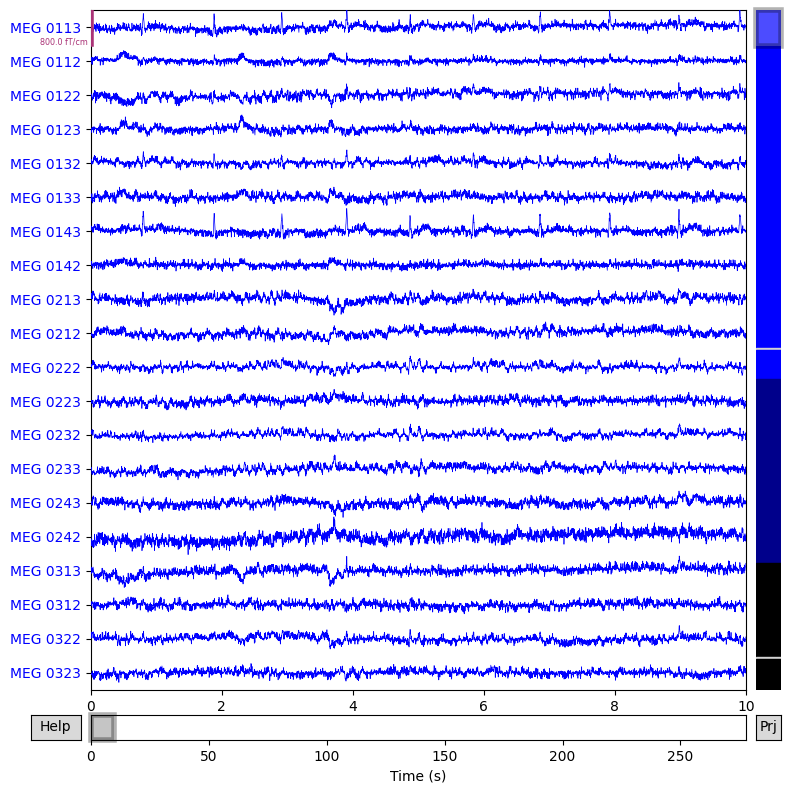

In [7]:
#%matplotlib qt
raw.plot();

L'ICA permet de décomposer les données (une matrice composée d'une série temporelle par capteur) en une somme de série temporelles (les Composantes Indépendantes) ayant chacune une répartition spatiale spécifique. En essence, ce principe ressemble beaucoup à une résolution du problème inverse : retrouver la source du signal en partant de l'activité observée sur les capteurs. Il y a en revanche une différence majeure : dans le cas de l'ICA, les "sources" sont caractérisées par une distribution spatiale, tandis que dans les cas de la reconstruction des sources, chaque source est limitée spatialement et ne décrit *que* l'activité présente à un endroit donné du cerveau. Cette différence fait de l'ICA un outil approprié pour capturer des artefacts qui affectent similairement l'ensemble du signal et qui ont une distribution spatiale particulière... ce qui est très exactement le cas des artefacts occulaires et cardiaques ! Voici une petite illustration pour vous aider à saisir le concept : 

L'ICA permet de décomposer les données (une matrice composée d'une série temporelle par capteur) en une somme de séries temporelles (les Composantes Indépendantes) ayant chacune une répartition spatiale spécifique. En essence, ce principe ressemble beaucoup à une résolution du problème inverse : retrouver la source du signal à partir de l'activité observée sur les capteurs. Cependant, il y a une différence majeure : dans le cas de l'ICA, les "sources" sont caractérisées par une distribution spatiale, tandis que dans les cas de la reconstruction des sources, chaque source est limitée spatialement et ne décrit *que* l'activité présente à un endroit donné du cerveau. Cette distinction fait de l'ICA un outil approprié pour capturer des artefacts qui affectent de manière similaire l'ensemble du signal et qui ont une distribution spatiale particulière, ce qui est précisément le cas des artefacts oculaires et cardiaques ! Voici une petite illustration pour vous aider à comprendre le concept :

![Principe simplifié de l'ICA](https://www.researchgate.net/profile/Ganesh-Naik-5/publication/228362813/figure/fig3/AS:301908859342850@1448992089716/Illustration-of-undercomplete-ICA.png)

Voyons comment opérationnaliser cette procédure (ne vous inquiétez pas ! Nous allons formuler cela sous forme de formule, mais je vais tout vous expliquer, promis) :

Nous souhaitons décomposer nos données $X \in \mathbb{R}^{C \times T}$

Ici, $X$ est donc une [matrice](https://fr.wikipedia.org/wiki/Matrice_%28math%C3%A9matiques%29) dont les éléments appartiennent à $\mathbb{R}$ (les nombres [réels](https://fr.wikipedia.org/wiki/Nombre_r%C3%A9el)), et de taille ${C \times T}$ (où $C$ représente le nombre de capteurs, et $T$ le nombre de points dans le temps).

L'équation que nous cherchons à résoudre peut donc s'écrire :

$$ X = As $$ 

où $A \in \mathbb{R}^{C \times C}$ est la matrice de poids (*mixing matrix*) et $s \in \mathbb{R}^{C \times T}$ sont les sources latentes indépendantes.

Dans notre cas, nous cherchons à estimer $A$ de manière à pouvoir décomposer/recomposer $A$, en omettant certaines sources $s$ que nous aurons identifiées comme étant des artefacts.

Il est important de noter que, pour que l'ICA fonctionne correctement, **le nombre de sources à séparer doit être inférieur au nombre de capteurs**.

Avant de procéder, il est crucial de garder à l'esprit que la décomposition ICA est très sensible au bruit dans le signal, en particulier dans les basses et très basses fréquences. **Il est souvent préférable de filtrer *agressivement* notre signal avant d'estimer $A$.** Il sera ensuite possible de décomposer et recomposer le signal non filtré à l'aide de la matrice obtenue sur le signal filtré.

In [8]:
raw_filtered = raw.filter(1., None, n_jobs=1, fir_design='firwin', verbose=False)

Maintenant, commençons par un exemple en quelques lignes pour avoir une idée globale du fonctionnement de l'objet [mne.preprocessing.ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html). Nous rentrerons dans les détails de l'utilisation de cette méthode dans la section suivante.

Commençons maintenant par un exemple afin d'avoir une idée générale du fonctionnement de l'objet [mne.preprocessing.ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html). Nous aborderons les détails de son utilisation dans la section suivante.

Fitting ICA to data using 364 channels (please be patient, this may take a while)


Selecting by number: 25 components
Fitting ICA took 29.9s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


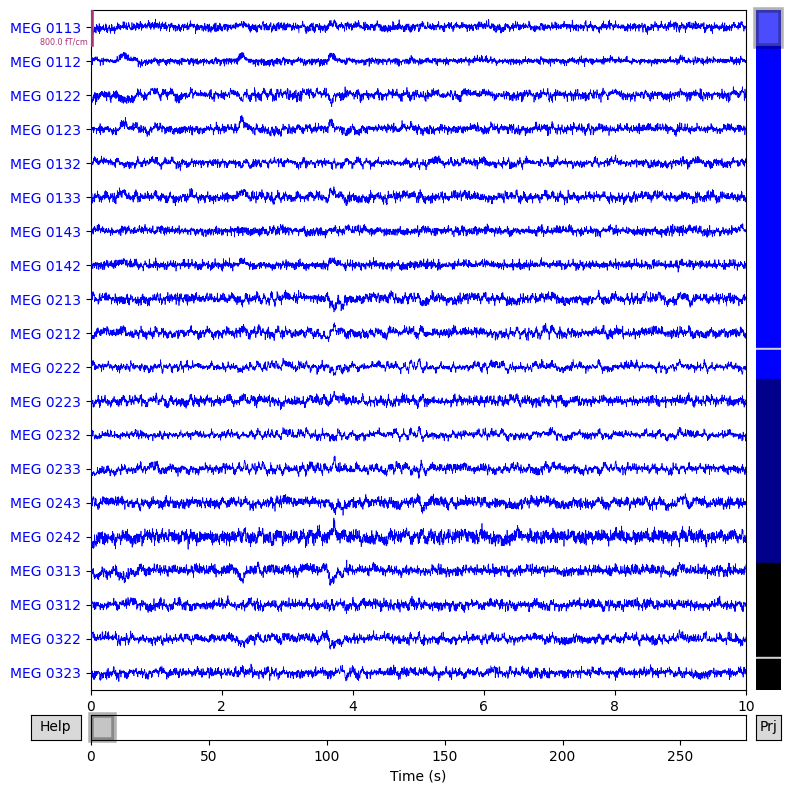

In [9]:
from mne.preprocessing import ICA

# Créer l'objet ICA
ica = ICA(n_components=25, method='fastica', random_state=42)

# "Fitter" l'objet ICA, c'est à dire calculer la matrice A
ica = ica.fit(raw_filtered)

# Exclure la seconde composante de la reconstruction (en Python, on compte à partir de 0)
ica.exclude = [1]

# Procéder à la reconstruction
raw_clean = ica.apply(raw.copy())

# Afficher le signal
raw_clean.plot();

In [22]:
# Question 5: Quel est l'effet de l'ICA sur le signal ?
# ADD DESCRIPTION HERE

In [10]:
del raw_clean, ica # Supprimez les objets 'raw_clean' et 'ica' pour libérer de la mémoire avant de passer à la suite.

## Initialiser l'ICA

Pour commencer, nous devons choisir l'algorithme qui sera utilisé pour la décomposition. MNE-Python propose quatre algorithmes différents : `fastica`, `picard`, `infomax` et `extended-infomax`. L'algorithme `fastica` est assez standard et surtout rapide à calculer, en faisant un bon choix pour les débutants dans cette méthode.

In [11]:
method = 'fastica'
decim = 3  # Pour augmenter la rapidité, nous utiliserons uniquement les trois premières décimales.

Ensuite, il nous faut choisir le nombre de composantes indépendantes que nous cherchons à obtenir. L'objectif ici est de garantir que les artefacts soient capturés par un nombre limité de composantes, et que ces composantes artefactuelles contiennent le moins possible de signal cérébral.

Pour ce faire, deux approches sont possibles :
- On peut spécifier directement le nombre de composantes désirées, par exemple 20 ou 25, ce qui est souvent une bonne valeur par défaut (**à condition d'avoir suffisamment de capteurs**).
- Alternativement, on peut spécifier une proportion de la variance totale à expliquer par les composantes indépendantes (par exemple, 0.95 pour 95%). Dans ce cas, le nombre de composantes peut varier d'un enregistrement à l'autre.

Dans cet exemple, nous utiliserons la première approche.

In [12]:
n_components = 25  
# Si cette valeur est un nombre décimal compris entre 0 et 1, le nombre de 3
# composantes sera déterminé en fonction de la proportion de variance expliquée

L'ICA est un algorithme non déterministe, ce qui signifie que le résultat obtenu dépend en partie du hasard. Pour ce tutoriel (et dans le but de garantir la **reproductibilité** de vos analyses), il est important de fixer l'état de notre générateur de nombres aléatoires, de sorte que la suite de nombres aléatoires utilisée par l'algorithme reste la même d'une utilisation à l'autre.

In [13]:
random_state = 42 # Cette valeur est arbitraire

Nous pouvons maintenant créer une instance de notre objet ICA.

In [14]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, method: fastica>


Souvenez-vous, l'ICA est très sensible au bruit environnemental. Il est donc préférable de procéder au calcul de $A$ sur un signal aussi propre que possible, ne contenant que les capteurs que l'on cherche à nettoyer. Pour cela, utilisons la méthode [mne.pick_types](https://mne.tools/stable/generated/mne.pick_types.html?highlight=mne%20pick_types#mne.pick_types) afin de ne sélectionner que les capteurs MEG. On peut aussi en profiter pour passer à l'objet d'ICA un dictionnaire de valeurs de seuil qui vont être utilisées pour rejeter les segments trop bruités qui risqueraient de perturber la décomposition.

In [15]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')

ica.fit(raw_filtered, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [16842, 17243]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [23258, 23659]
    Rejecting  epoch based on MAG : ['MEG 0131']
Artifact detected in [49323, 49724]
Selecting by number: 25 components
Fitting ICA took 17.3s.
<ICA | raw data decomposition, method: fastica (fit in 48 iterations on 54135 samples), 25 ICA components (305 PCA components available), channel types: mag, grad, no sources marked for exclusion>


Maintenant que les composantes indépendantes ont été obtenues, nous pouvons visualiser leur distribution spatiale pour commencer à les identifier. Pouvez-vous repérer celles qui pourraient être associées à des battements cardiaques ou à des clignements des yeux ?

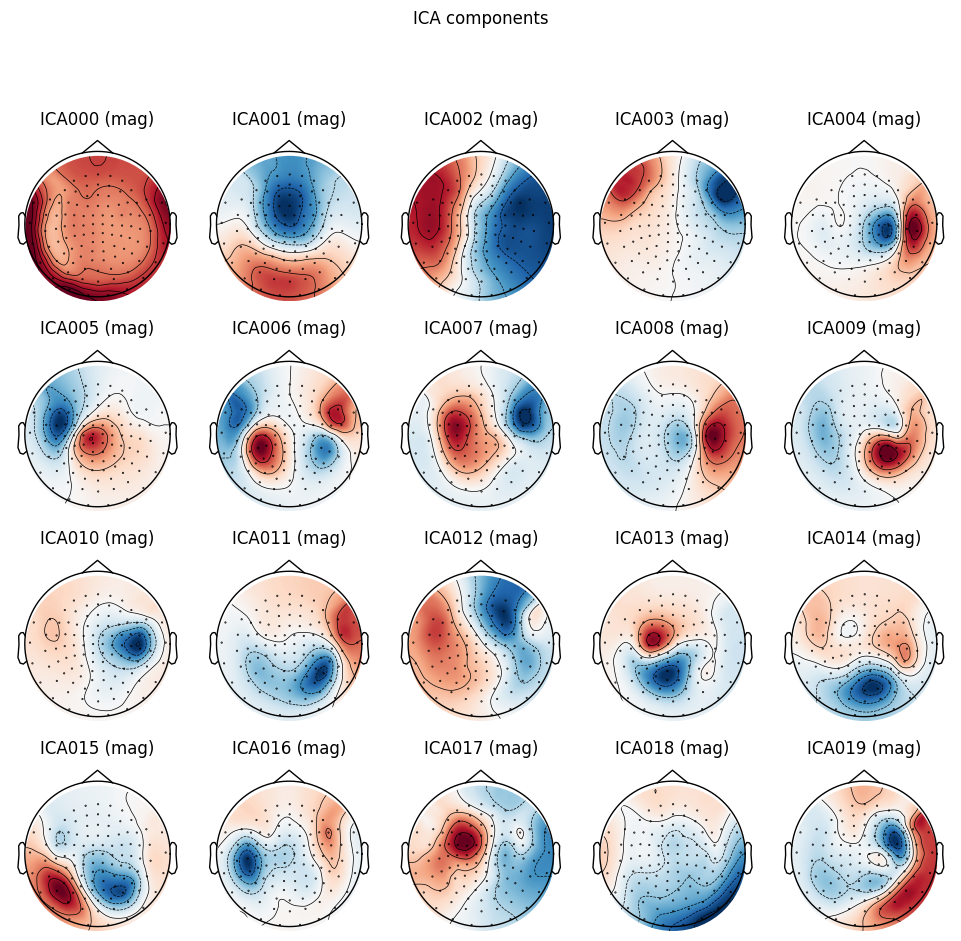

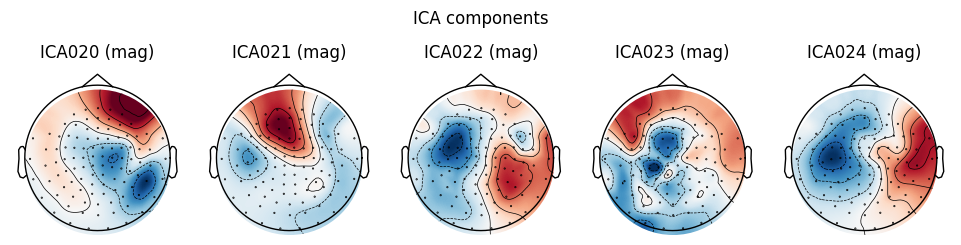

In [16]:
ica.plot_components(sphere=0.18, extrapolate="head");

Il est souvent bénéfique d'inspecter également les séries temporelles de ces composantes.

Creating RawArray with float64 data, n_channels=26, n_times=166800
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


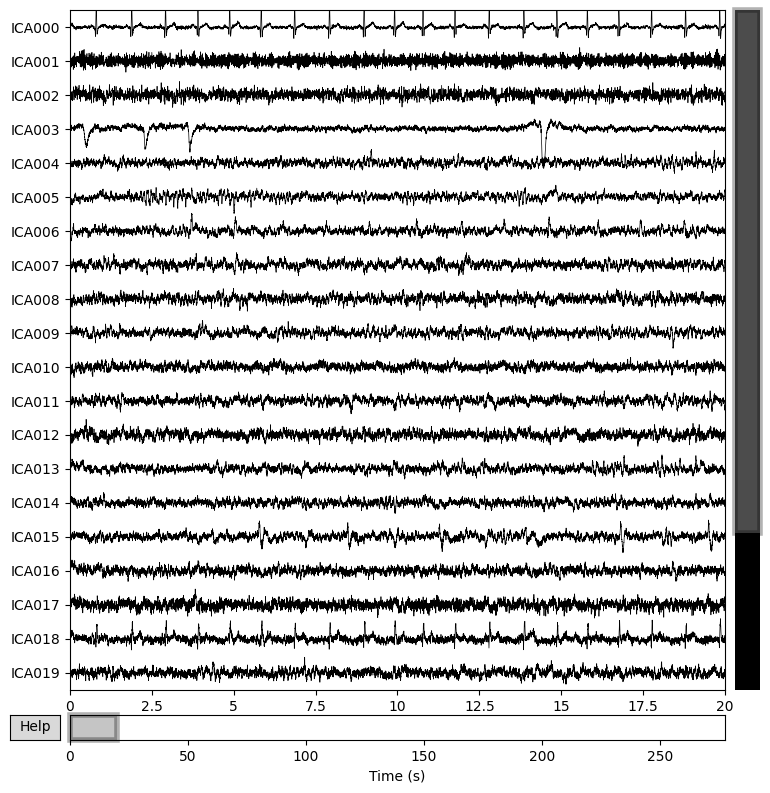

In [17]:
ica.plot_sources(raw);

- Les battements cardiaques sont caractérisés par un pattern régulièrement espacé et très distinctif : on peut quasiment reconnaître le [complexe QRS](https://en.wikipedia.org/wiki/QRS_complex). Leur topographie est généralement très étendue, et il arrive souvent qu'un seul pôle soit visible (bleu ou rouge).

- Pour les clignements des yeux, on s'attend à observer une distribution principalement pré-frontale, avec une forte  latéralisation des pôles (rouge d'un côté, bleu de l'autre). Sur le tracé, les clignements des yeux se remarquent à leur forme caractéristique et à leur occurence apparemment aléatoire.

- On peut aussi parfois retrouver d'autres composantes ayant capturé les mouvements de poursuite occulaire lente, avec une distribution semblable à la composante de clignements des yeux, mais avec un profil temporel différent.

In [ ]:
# Question 6: Faire la même chose pour les capteurs EEG:
ica_eeg = ICA(n_components=n_components, method=method, random_state=random_state)
reject_eeg = dict(eeg=80e-6)

picks_eeg = mne.pick_types(raw.info, meg=ADD CODE HERE, eeg=ADD CODE HERE, eog=False,
                           stim=False, exclude='bads')

ica_eeg.fit(raw_filtered, picks=ADD CODE HERE, decim=decim, reject=reject_eeg)

ica_eeg.plot_components();

## Détection automatique des composantes artefactuelles

Dans un souci de reproductibilité (ou par simple commodité), il est souvent préférable d'établir une procédure fixe pour identifier les composantes artefactuelles. Cela devient particulièrement crucial lorsque vous avez un grand volume de données à traiter, car le choix des composantes à conserver ou à supprimer peut varier en fonction des critères du chercheur responsable du nettoyage (c'est-à-dire vous).

Pour ce faire, il est possible de corréler nos différentes composantes indépendantes avec le signal EOG (qui enregistre l'activité oculaire) ou l'ECG (pour l'activité cardiaque). Voici comment procéder :
- Créez des segments de notre signal EOG/ECG en fonction de la détection d'événements (clignements ou battements).
- Calculez un score de corrélation entre ces segments et les différentes composantes indépendantes.
- Supprimez du signal les composantes dont le score de corrélation dépasse un certain seuil.

Le paramètre principal sur lequel vous pouvez agir est donc le seuil de corrélation au-delà duquel une composante sera considérée comme artefactuelle. Assurez-vous de choisir cette valeur de seuil de manière à ce que *toutes les composantes artefactuelles, et seulement celles-ci, soient détectées et supprimées.*

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46
Not setting metadata
46 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 46 events and 601 original time points 

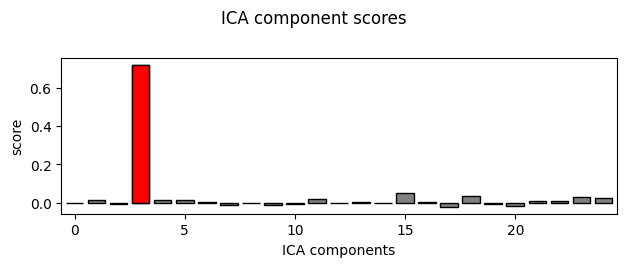

In [19]:
from mne.preprocessing import create_eog_epochs

# Obtenir les segments basés sur l'EOG
eog_epochs = create_eog_epochs(raw, reject=reject)

# Calculer la corrélation de chaque composante avec ces segments
eog_inds, scores = ica.find_bads_eog(eog_epochs)  

# Inspecter visuellement les composantes détectées (en rouge sur le graph)
ica.plot_scores(scores, exclude=eog_inds);  

On peut maintenant afficher les propriétés de la/des composante(s) détectée(s). Afin de rendre le graphique facilement interprétable, ajustons les arguments passés à la fonction en charge de générer le spectre :

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


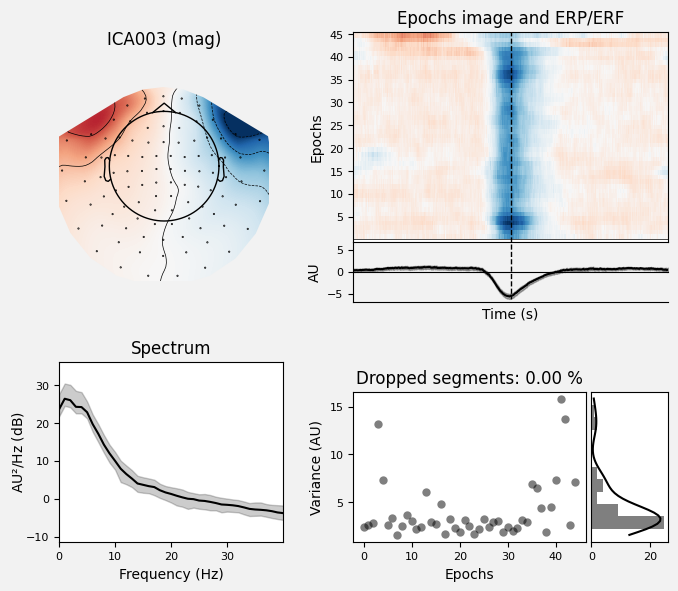

[<Figure size 700x600 with 6 Axes>]

In [20]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.},
                    image_args={'sigma': 1.})

In [22]:
from mne.preprocessing import create_ecg_epochs

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Number of ECG events detected : 283 (average pulse 61 / min.)
Not setting metadata
Not setting metadata
283 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 283 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on MAG : ['MEG 0131', 'MEG 1511']
3 bad epochs dropped
Reconstructing EC

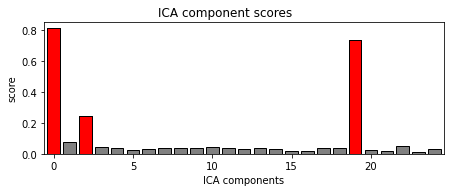

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


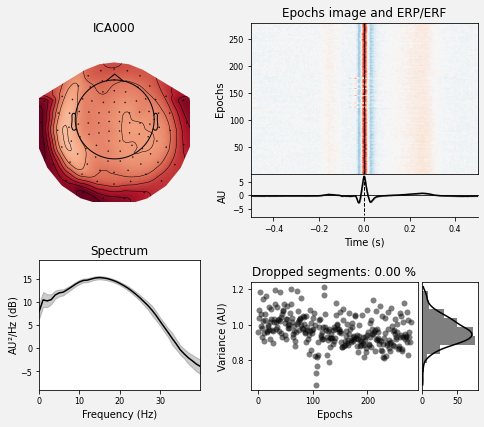

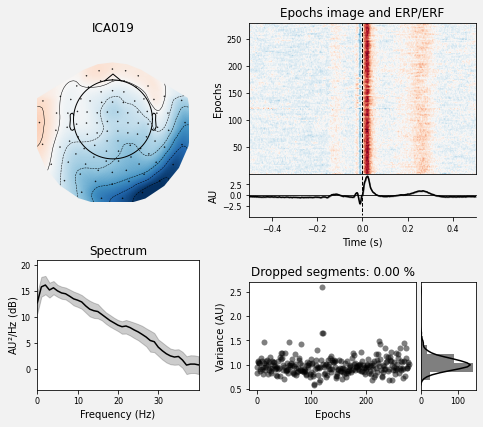

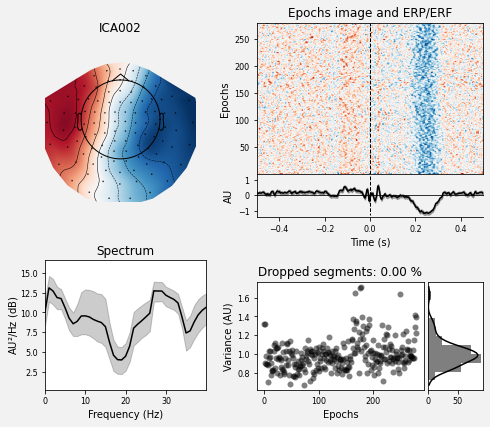

In [21]:
# Question 7: Faire la même chose pour les capteurs ECG:

ecg_epochs = ADD CODE HERE
ecg_inds, scores = ADD CODE HERE # Hint: utiliser la fonction 'find_bads_ecg' 

ica.plot_scores(scores, exclude=ecg_inds);
ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 40.},
                    image_args={'sigma': 1.});

Espérons que ça a plutôt bien fonctionné ! Malheureusement, la composante ICA002 a été détectée comme capturant les battements cardiaques, mais l'inspection des séries temporelles suggère qu'il ne s'agit pas de battements cardiaques. Il serait donc approprié de modifier notre seuil pour conserver cette composante

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

Number of ECG events detected : 283 (average pulse 61 / min.)
Not setting metadata
283 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 283 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0131', 'MEG 1511']
    Rejecting  epoch based on MA

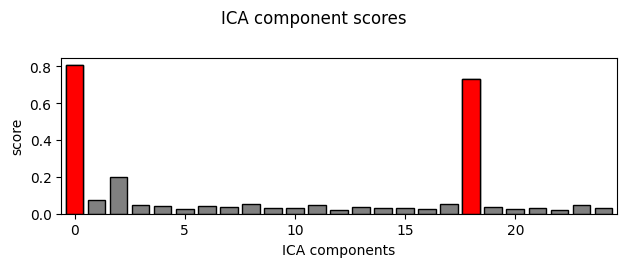

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated


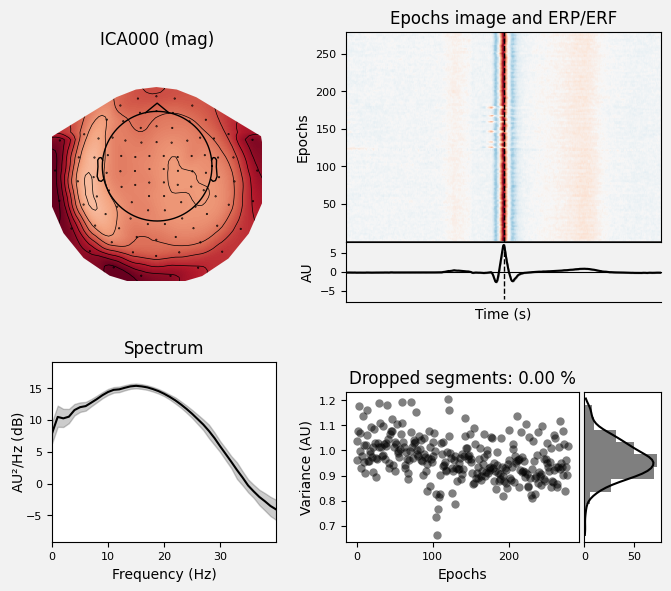

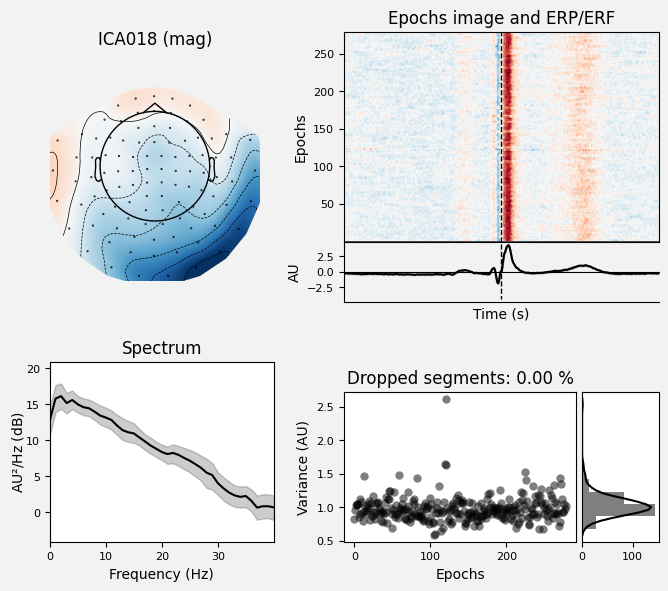

In [23]:
ecg_epochs = create_ecg_epochs(raw, reject=reject)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, threshold = 0.5) # On change le seuil ici

ica.plot_scores(scores, exclude=ecg_inds);
ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 40.},
                    image_args={'sigma': 1.});

Notez qu'aucune donnée n'a encore été retirée : nous nous sommes simplement contentés d'estimer les composantes et de détecter celles qui capturaient nos artefacts. Il est maintenant nécessaire de recomposer le signal 'propre' à partir de l'objet `raw` *avant* le filtrage passe-haut à 1 Hz. Pour ce faire, utilisez la méthode `mne.preprocessing.ICA.apply` en lui passant les indices des composantes détectées.

Je vous laisse admirer le résultat !

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 305 PCA components


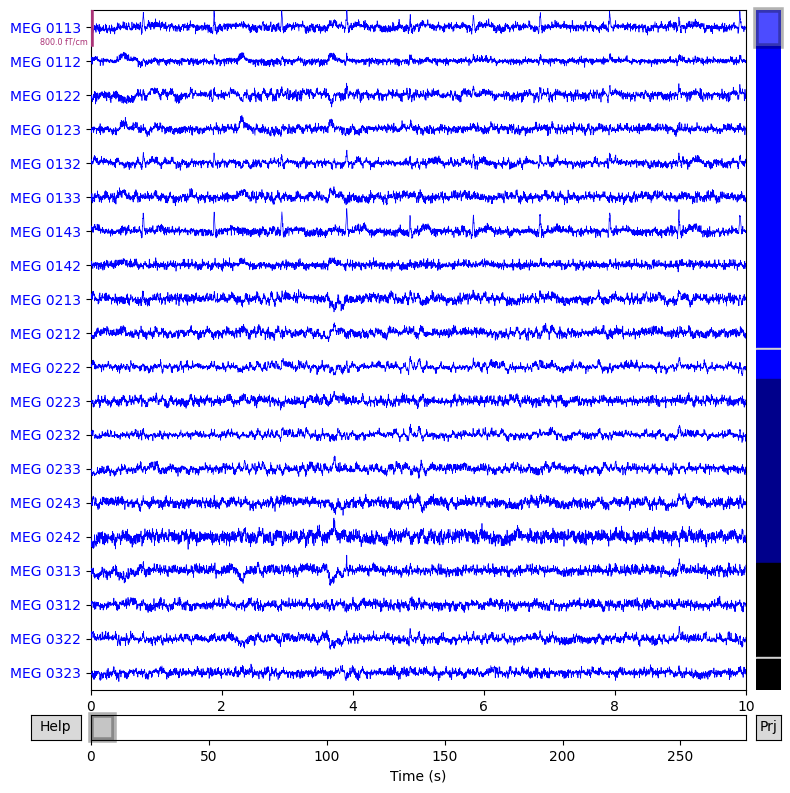

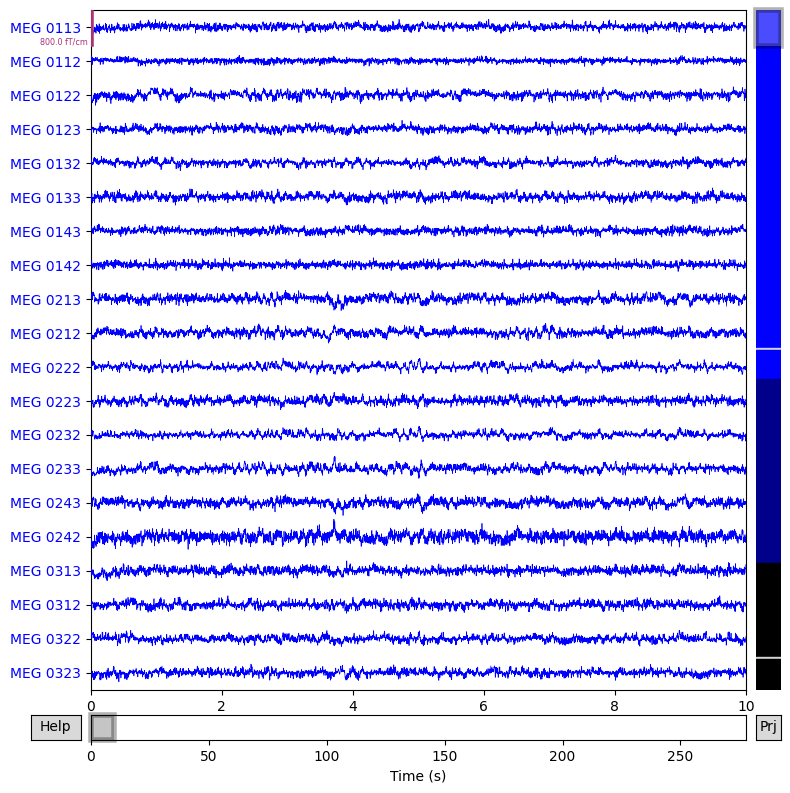

In [24]:
# L'attribut "exclude" garde une trace des composantes à exclure lors de la recomposition 
ica.exclude.extend(eog_inds) 
ica.exclude.extend(ecg_inds)

raw_copy = raw.copy()
# Ici, la méthode "apply" permet de recomposer le signal de raw_copy en excluant les composantes marquées
ica.apply(raw_copy) 
raw.plot();
raw_copy.plot();

Maintenant que notre signal est tout beau tout propre, sauvegardons-le avant de passer à l'étape suivante. C'est ce dataset nettoyé que nous utiliserons pour les activité suivantes.

In [25]:
clean_fname = os.path.join(mne.datasets.sample.data_path(), 'MEG/sample/sample_audvis_clean.fif')
raw_copy.save(clean_fname, overwrite=True)

Overwriting existing file.
Writing /Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_clean.fif


/var/folders/dy/yqsbvh6j7r7gz1ktnr8gx4g80000gn/T/ipykernel_10280/3069452826.py:2: RuntimeWarning: This filename (/Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_copy.save(clean_fname, overwrite=True)


Closing /Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_clean.fif
[done]


## Ajuster les seuils de réjection d'artefacts

Certains artefacts ne peuvent pas être retirés en filtrant les données ou en les nettoyant à l'aide d'une ICA. Par exemple, lorsqu'un sujet serre les mâchoires, parle ou bouge beaucoup, le signal sera complètement dominé par des artefacts. Le plus simple est alors de détecter les segments contaminés et de les rejeter ou de les réparer lorsque c'est possible.

Ces segments se caractérisent par une forte variance (le signal passe très rapidement de valeurs très négatives à des valeurs très positives ; visuellement, cela ressemble souvent à un gros pic). Ils peuvent donc être repérés en comparant la variance observée dans chaque segment à une valeur de seuil, au-delà duquel on jugera un segment inexploitable.

Voyons comment choisir ce seuil et comment ce choix impacte les données.

Pour illustrer cette étape, nous n'utiliserons que les canaux EEG de notre dataset, puisque ceux-ci sont les plus sensibles à ce type d'artefacts de mouvement. Toutefois, cette technique est aussi couramment utilisée sur le signal MEG.

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


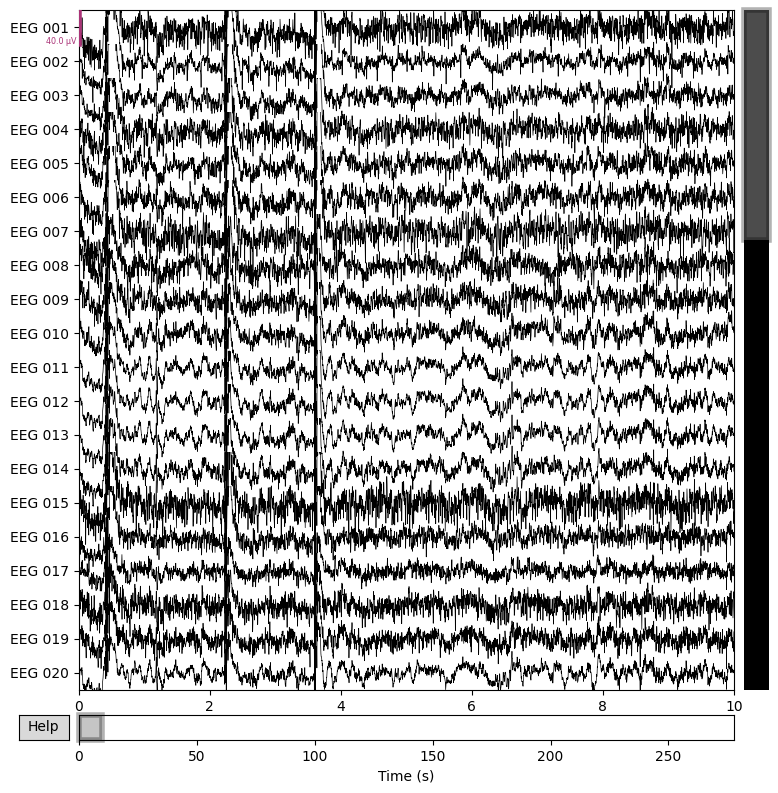

In [26]:
raw = raw_copy
# Maintenant, commençons par afficher le signal EEG
raw.copy().pick_types(eeg=True).plot(); 

Nous allons maintenant segmenter les données afin de créer une représentation de l'activité évoquée par l'événement "auditory/left". Préparons d'abord quelques paramètres

In [28]:
# Cette ligne de code permet de sélectionner les segments de données correspondant à un stimulus auditif gauche
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {"auditory/left": 1}
# Cette ligne définit les limites temporelles des segments de données
tmin, tmax = -0.2, 0.5
# Cette ligne définit le dictonnaire baseline
baseline = (None, 0)

320 events found
Event IDs: [ 1  2  3  4  5 32]


Maintenant, nous pouvons appeler l'objet Epochs afin de segmenter les données. Nous allons mettre l'argument "reject" à None afin d'explorer son impact dans les prochaines cellules. En temps normal, c'est par cet argument que vous indiquerez le seuil au delà duquel vous souhaitez rejeter un segment.

In [29]:
picks = mne.pick_types(raw.info, meg=False, eeg=True)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                   
                    preload=True)

Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
3 projection items activated
Using data from preloaded Raw for 72 events and 421 original time points ...
0 bad epochs dropped


Pour illustrer l'impact du seuil sur le potentiel évoqué, créons un petit graphique interactif :

In [30]:
from ipywidgets import interact
def reject_epochs(reject): # On definit une fonction qui prend en entrée un seuil de rejet
    reject = dict(eeg=reject * 1e-6)
    evoked = epochs.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True, verbose=False)
    print(f'Number of epochs retained: {evoked.nave}/{len(epochs)}')

Maintenant, roulez la cellule ci-dessous et déplacez le curseur "reject" afin de faire varier la quantité de segments qui seront inclus dans le calcul du potentiel évoqué. Que remarquez-vous ?

In [31]:
interact(reject_epochs, reject=(40, 250, 10));

interactive(children=(IntSlider(value=140, description='reject', max=250, min=40, step=10), Output()), _dom_cl…

Plus le seuil et bas, et moins le nombre de segments retenu sera élevé, notre potentiel évoqué sera donc très bruité. Inversement, si le seuil est trop haut alors tous les segments seront utilisés lors du moyennage, incluant les segments très bruités, ce qui va aussi altérer notre PE. Il faut donc choisir un seuil optimal, qui va rejeter les epochs les plus bruitées et **seulement celles-ci** afin d'avoir un PE aussi propre que possible.

Mais alors, comment choisir ce seuil ?

## Autoreject

[AutoReject](https://autoreject.github.io/index.html) est un algorithme permettant d'estimer automatiquement les seuils optimaux afin de détecter les segments et/ou les cannaux bruités. Lorsqu'un segment/canal est détecté, AutoReject va tenter de le réparer par interpolation ou va le rejeter si c'est impossible.

Pour faire simple, AutoReject est donc un moyen *data-driven* de générer un dictionnaire "reject" (comme celui vu plus haut) optimal. Voyons comment cet outil fonctionne.

In [32]:
from autoreject import get_rejection_threshold
reject = get_rejection_threshold(epochs) # Aussi simple que ça !
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 0.00012969120599376434}


Et voilà ! Notre seuil pour ce signal EEG pourrait donc être 0.000130. Néanmoins, le seuil optimal n'est pas nécessairement le même d'un canal à l'autre, ou d'une modalité (MEG, EEG etc...) à l'autre. Il est donc possible d'estimer séparément un seuil pour chaque canal. Pour cela, nous utiliserons un [objet AutoReject](https://autoreject.github.io/generated/autoreject.AutoReject.html#autoreject.AutoReject).

In [33]:
from autoreject import AutoReject

# Définissons quelques paramètres.
n_interpolates = np.array([1, 2, 4])
consensus = np.linspace(0.5, 1.0, 6)

# Créons une instance d'objet AR
ar = AutoReject(n_interpolates, consensus, thresh_method='random_search',
                random_state=42)

In [34]:
# Enfin, appelons la méthode .fit() afin d'estimer les seuils à partir des données epochs['auditory/left']
ar.fit(epochs['auditory/left'])

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/59 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/59 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


AutoReject(consensus=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), cv=10,
      n_interpolate=array([1, 2, 4]), n_jobs=1, picks=None,
      random_state=42, thresh_method='random_search', verbose=True)

On peut accéder aux seuils estimés par l'attribut .threshes_ de l'objet ar.

EEG 001: 7.206582986491884e-05
EEG 002: 0.00012588219688069714
EEG 003: 4.222435734544544e-05
EEG 004: 8.446827217810727e-05
EEG 005: 7.527651829535234e-05


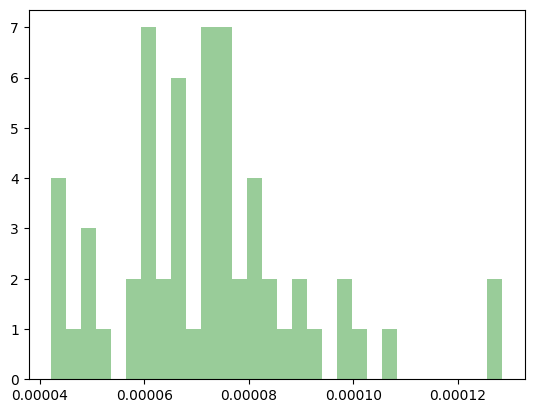

In [35]:
for ch_name in epochs.info['ch_names'][:5]:
     print(f'{ch_name}: {ar.threshes_[ch_name]}')
        
plt.hist(np.array(list(ar.threshes_.values())), 30, color='g', alpha=0.4);

On peut aussi inspecter visuellement les canaux et segments qui ont été rejetés. Pour cela, on peut utiliser le [RejectLog](https://autoreject.github.io/generated/autoreject.RejectLog.html#autoreject.RejectLog) fourni par AutoReject.

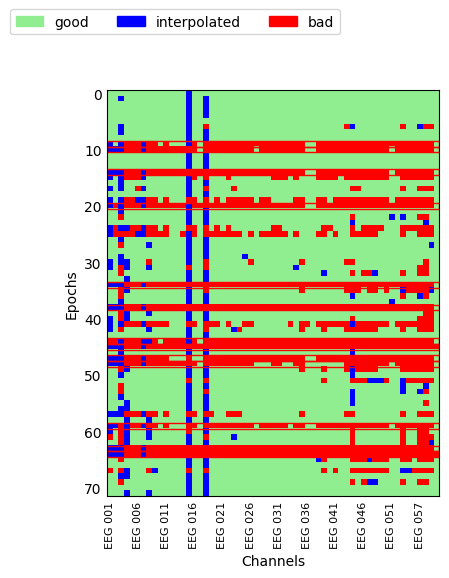

In [36]:
reject_log = ar.get_reject_log(epochs['auditory/left'])
reject_log.plot();

Alternativement, on peut aussi afficher les données sous forme de séries temporelles. Encore une fois, ce graphique peut être interactif.

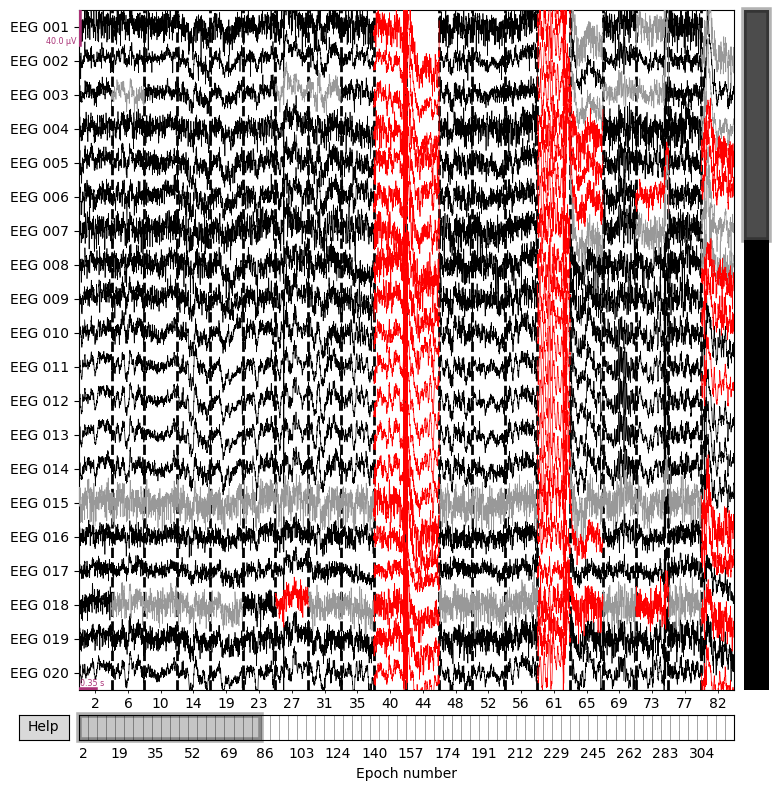

In [37]:
reject_log.plot_epochs(epochs['auditory/left']);

Enfin, comme pour l'ICA, la correction n'est pas appliquée automatiquement une fois qu'elle est calculée. Pour cela, il faut appeler la méthode .transform().

In [38]:
epochs_clean = ar.transform(epochs['auditory/left'])

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

Dropped 13 epochs: 9, 10, 14, 20, 34, 38, 44, 45, 47, 48, 59, 63, 64


C'est terminé ! Notre signal est maintenant beaucoup plus propre, et on peut procéder à des analyses pour (1) tester la qualité du nettoyage des données (faire ce qu'on appelle des *sanity checks*) et (2) tester nos hypothèses scientifiques.
Comparons les potentiels évoqués avant et après le nettoyage par AutoReject. Combien d'epochs ont été rejetées par cette méthode ? Est-ce que cela améliore le PE, ne serait-ce qu'un peu ?

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


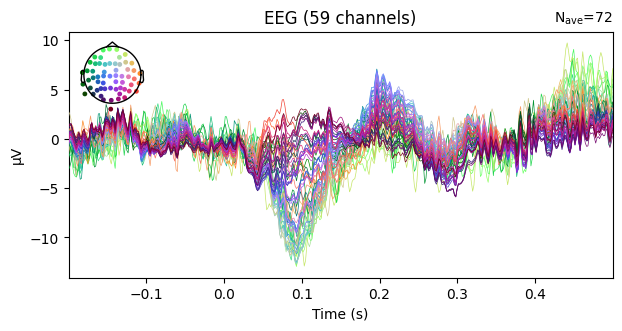

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


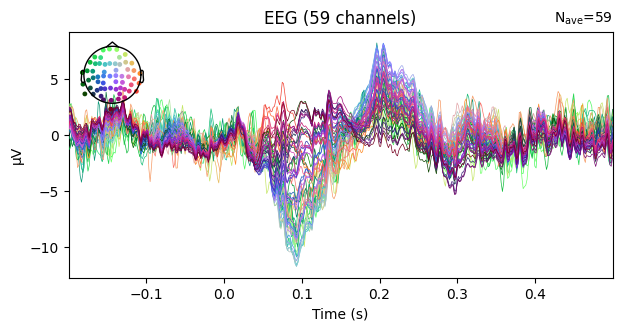

In [39]:
evoked = epochs['auditory/left'].average()
evoked.plot(exclude=[], picks='eeg');

evoked_clean = epochs_clean.average()
evoked_clean.plot(exclude=[], picks='eeg');

In [ ]:
# Question 8: Faire la même chose pour les capteurs MEG:
ADD CODE HERE # Tout le code est déjà écrit ci-dessus, il vous suffit de copier/coller et de l'adapter aux données MEG.

In [ ]:
# Question 9: Faire la même chose pour event_id = {"auditory/right": 2}:
ADD CODE HERE # Tout le code est déjà écrit ci-dessus, il vous suffit de copier/coller et de l'adapter au event_id.

In [57]:
#Question 10: Optionel: Faire la même chose pour 
# event_id = {"visual/left": 3}; event_id = {"visual/right": 4}:
# event_id = {"smiley": 5};
# C'est pour comparer les differents types de stimuli.

## Conclusion

Une fois que les données ont été débarrassées de leurs principaux artefacts, vous pouvez désormais les analyser et les utiliser pour tester vos hypothèses. La qualité de vos analyses dépendra de la qualité de votre nettoyage. Il est donc recommandé de commencer par des analyses de *sanity check* (par exemple, en testant une hypothèse "évidente" basée sur un phénomène bien connu, tel que le rebond bêta après une réponse motrice, ou la désynchronisation alpha en lien avec la tâche). Si ces analyses échouent, il est probable que votre nettoyage doive être amélioré ! Prenez le temps d'expérimenter avec les différents paramètres de nettoyage jusqu'à trouver la procédure qui convient le mieux à vos données.